# Part 9: Results and discussion

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("..")

## A. Results comparison

We first start by comparing the test accuracies of our models and those of the SLF.

Let's recall, the SLF trained two different random forests called RF1 and RF2. According to [[1]](#ref1), RF1 was trained on the same dataset (named $D_{forecast}$ by the SLF) than us, while RF2 was trained on a quality-controlled subset of danger level (named $D_{tidy}$ by the SLF). Then both RF1 and RF2 were tested on both sets. RF1 got an accuracy of 74% on $D_{forecast}$ and 76% on $D_{tidy}$ while RF2 got 72% on $D_{forecast}$ and 78% on $D_{tidy}$.

We will only compare the results of RF1 trained and tested on $D_{forecast}$ with the ones of our models.

In [3]:
# Loading the test accuracies of our models
acc_baseline = np.load("../scores & pca components/acc_baseline.npy")
acc_dt = np.load("../scores & pca components/acc_dt.npy")
acc_rf = np.load("../scores & pca components/acc_rf.npy")
acc_logreg = np.load("../scores & pca components/acc_logreg.npy")
acc_nn = np.load("../scores & pca components/acc_nn.npy")

In [4]:
# Storing the results in a DataFrame
df_results = pd.DataFrame({
    "model": ["Baseline", "Decision Tree", "Random Forest", "Logistic Regression", "Neural Network", "RF1"],
    "test accuracy": np.round([acc_baseline, acc_dt, acc_rf, acc_logreg, acc_nn, 0.74],2),
    "macro f1": [0.14, 0.48, 0.53, 0.63, 0.51, 0.7]
})

df_results.sort_values(by = "test accuracy", inplace = True, ascending = True)
df_results.reset_index(inplace = True, drop = True)
df_results

,model,test accuracy,macro f1
0,Baseline,0.39,0.14
1,Decision Tree,0.64,0.48
2,Neural Network,0.67,0.51
3,Random Forest,0.68,0.53
4,Logistic Regression,0.71,0.63
5,RF1,0.74,0.70


In [5]:
# Function to add labels on top of the bars given x, y
def add_labels(x, y, h_ratio):
    for i in range(len(x)):
        
        plt.text(x=i, 
                 y=y[i] + y[i]*h_ratio,
                 s=y[i],
                 ha='center')

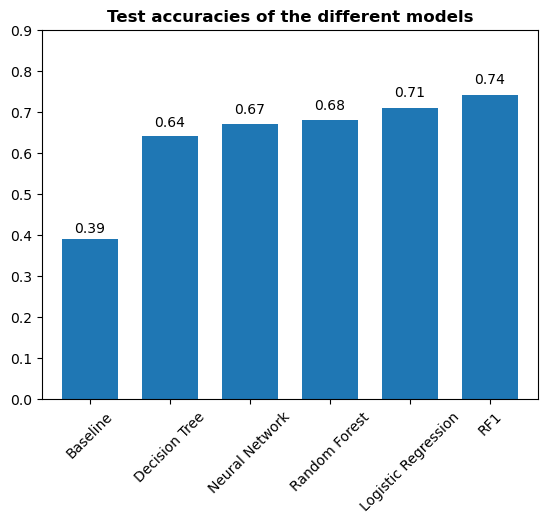

In [6]:
# Plot the test accuracies
df_results["test accuracy"].plot.bar(legend = False, width = .7)

add_labels(x = df_results["model"],
           y = df_results["test accuracy"], h_ratio = 0.04)

plt.xticks(ticks = np.arange(0,6), labels = df_results["model"], rotation = 45)
plt.title("Test accuracies of the different models", fontsize = 12, fontweight = "bold")
plt.yticks(np.arange(0,1,0.1))
plt.show()

The least accurate model we trained is the Decision Tree, while the Neural Network and the Random Forest got an equivalent accuracy. We can still say these accuracies are acceptable compared to that of the baseline model. They achieved more than 20 percentage points higher accuracy than the latter.

Our best model is the Logistic Regression with an accuracy of 0.71 and it is not that far from that of RF1.

We plot below the macro $F_{1}$ scores of the different models. According to [[1]](#ref1), RF1 achieved a macro $F_{1}$ score of 0.7. 

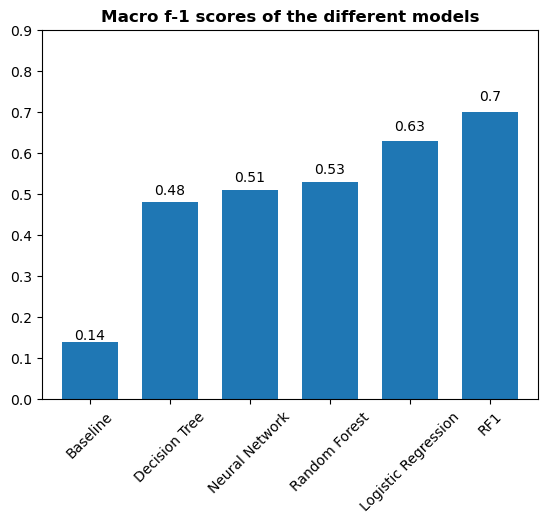

In [7]:
# Plot the macro F1 scores
df_results["macro f1"].plot.bar(legend = False, width = .7)

add_labels(x = df_results["model"],
           y = df_results["macro f1"], h_ratio = 0.04)

plt.xticks(ticks = np.arange(0,6), labels = df_results["model"], rotation = 45)
plt.title("Macro f-1 scores of the different models", fontsize = 12, fontweight = "bold")
plt.yticks(np.arange(0,1,0.1))
plt.show()

According to [[1]](#ref1), RF1 correctly classified danger level 4 in 51.4% of the cases, while 48.6% of the predictions were assigned to class 3. This is significantly better than our Logistic Regression model, which, for comparison, classified level 4 correctly only 20% of the time and predicted class 3 in 78% of the cases.

## B. Discussion 

We would like to compare the approach and decisions chosen by the SLF researchers and ours which could explain the accuracy difference. We indeed think that it can mainly be explained by the differences of approach in the preprocessing steps, rather than the parameter of the classifier settings. We outline the most relevant ones here.

### B. 1. Handling the imbalanced nature of the data

The main challenge about predicting the danger level is again the extremely imbalanced character of the data. We saw that the danger level 1 represents around 20% of the data, 40% for danger level 2 , 36% for danger level 3, 1.7% for danger level 4 and 0.06% for danger level 5. 

Like us, the SLF merged the classes of danger level 4 and 5. Merging the two categories becomes a classification task into 4 classes, this may reduce the risk of false labelling and works toward slightly better predictions. 

Another strategy to solve this issue would have been either over-sampling the minority classes or down-sampling the majority classes or both together. The researchers say [[1]](#ref1) that they tried both strategies, without any performance improvement. 

We also investigated if setting the parameter `class_weight` to "balanced" was guaranteeing better performance for the Decision Tree and the Random Forest at least. This parameter setting induced even worse results. This is due to the very poor representation of the minority classes. On the contrary, RF1 was trained with this set-up [[2]](#ref2). What we could have done is to fine-tune the `class_weight` parameter of every classifier by exploring different weights assigned to classes other than just setting it to "balanced" and give a lot more weight to the fourth class. 

### B. 2. Data management

The SLF researchers split their data from the season 2018/2019 instead of 2017/2018 as we did, this allowed the training set to be a bit bigger. One might think that this works towards achieving better results. We think that since our dataset and trainingset are already large, this should not have made any big difference. 

Also, the SLF researchers didn't remove any outliers during data preprocessing. On the contrary, we removed around 3.5% of the samples. Even if in theory more samples means that the model can train more, difference of the size of the sample is too little. We don't think it's the reason of such difference in the model performances either. 

### B. 3. Feature selection and engineering

We think that the feature selection and engineering are probably what explain most of the performance difference between our Random Forest Classifier and those trained by the SLF. 

The SLF selected the features with the following criteria [[1]](#ref1), [[2]](#ref2): 

- train the Random Forest first with every feature and obtain the feature importance scores by calling the attribute `feature_importances_` of the Random Forest Classifier provided by scikit-learn. 

- for highly correlated meteorological variables pairs, keep the one with the greatest importance score according to the Random Forest model. 

- for highly correlated profile variables pairs, keep the one from the uppermost weak layer because it is more prone to break than the lower layers. 

- remove manually `TS0`, `TS1`, `TS2`, the snow temperatures at 0.25m, 0.5m and 1m above ground. Because <i>"their incorporation into the model requires a larger minimum snow depth (>100 cm) for meaningful measurements."</i> Which does indeed make sense. 

- use [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html) RFE from scikit-learn. Given an estimator and a number of desired features, RFE aims to select features by recursively considering smaller and smaller sets of features until returning the best subset of features according to the desired number. The SLF set the number to 30 and applied this method on the Random Forest Classifier. This choice was made according to the following statement: <i>"To explore this number, we wrapped a random forest classifier, which was trained with a variable number of features. Features were added in descending order from the most to the least important in the score ranking estimated by the random forest."</i>

The idea of exploring the importance scores of the features and recursively selecting the best possible subset of features, is what probably explains the significant difference of accuracy between our Random Forest and theirs. 

We can outline what the differences between our feature space and that of the SLF.The SLF's final set of features can be found in the code provided in [[2]](#ref2).

In [8]:
# Define both features selected by the SLF and our features
features_SLF = ['HN72_24', 'HN24', 'HN24_7d', 'Pen_depth', 'min_ccl_pen', 'MS_Snow', 'wind_trans24_3d', 'wind_trans24_7d',
                'RH', 'wind_trans24', 'TA', 'pAlbedo', 'Sn', 'S4', 'LWR_net', 'Qs', 'ILWR', 'Qw', 'VW', 'ccl_pwl_100', 'ISWR',
                'HS_mod', 'zSn', 'TSS_mod', 'Qg0', 'ISWR_diff', 'VW_drift', 'sn38_pwl_100', 'zSs', 'Ss']

features = pd.read_csv("../datasets/train_data.csv").drop("dangerLevel", axis = 1).columns.to_list() # Without taking danger level


In [9]:
# Getting the definition of features

meta_data_1 = pd.read_excel("../datasets/nhess-22-2031-2022-t05.xlsx") # Meteorological variables
meta_data_2 = pd.read_excel("../datasets/nhess-22-2031-2022-t06.xlsx") # Profile variables
meta_data = pd.concat([meta_data_1, meta_data_2], axis=0)
meta_data.reset_index(drop=True, inplace=True)

In [10]:
# Providing the difference between both sets containing the features

A = set(features)
B = set(features_SLF)

C = list(A.difference(B))
C.sort() # Sort in alphabetic order
D = list(B.difference(A))

In [11]:
# Show the features that we decided to select on the contrary of the SLF
C

['HS_meas',
 'MS_water',
 'No HN24',
 'No HN24_7d',
 'No HN72_24',
 'No HS_meas',
 'No hoar_size',
 'No wind_trans24',
 'No wind_trans24_3d',
 'No wind_trans24_7d',
 'Ql',
 'Sclass2',
 'Sd',
 'TS0',
 'TS1',
 'TS2',
 'TSS_meas',
 'T_bottom',
 'base_pwl',
 'hoar_size',
 'month_cos',
 'month_sin',
 'sn38_pwl',
 'zSd']

We see that some of these variables are either the indicator variables we built, or cyclic features encoding the months of the observation. Let's check the definition of the remaining features:


In [12]:
meta_data[meta_data["Feature name"].isin(C)]

,Feature description,Feature name,Type,Selected/discarded
1,Latent heat [W m−2],Ql,Modelled,Discarded: RFE
17,Surface temperature [∘C],TSS_meas,Measured,Discarded: correlation
18,Bottom temperature [∘C],T_bottom,Modelled,Discarded: correlation
25,Snow height [cm],HS_meas,Measured,Discarded: correlation
26,Hoar size [cm],hoar_size,Modelled,Discarded: RFE
34,Total amount of water [kg m−2],MS_water,Modelled,Discarded: RFE
40,Snow temperature at 0.25 m [∘C],TS0,Measured,Discarded: manually
41,Snow temperature at 0.5 m [∘C],TS1,Measured,Discarded: manually
42,Snow temperature at 1 m [∘C],TS2,Measured,Discarded: manually
43,Stability class [–],Sclass2,Modelled,Discarded: RFE


Apart from `TS0`, `TS1`, `TS2` (that we didn't question the relevance and it would have been a good idea to do so), all these variables were either removed because they were highly correlated or eliminated through RFE. We did remove highly correlated variables, but we just did not have as precise criteria, domain knowledge based, as the SLF. 

Let's see what are the features that the SLF selected while we didn't. 

In [13]:
D

['ccl_pwl_100', 'sn38_pwl_100', 'TSS_mod', 'ILWR', 'HS_mod', 'zSs']

In [14]:
meta_data[meta_data["Feature name"].isin(D)]

,Feature description,Feature name,Type,Selected/discarded
6,Incoming long-wave radiation [W m−2],ILWR,Modelled,Selected
16,Surface temperature [∘C],TSS_mod,Modelled,Selected
24,Snow height [cm],HS_mod,Modelled,Selected
49,Depth of Sk38 skier stability index [m],zSs,Modelled,Selected
62,Natural stability index at surface weak layer [–],sn38_pwl_100,Profile,Selected
64,Critical cut length at surface weak layer [m],ccl_pwl_100,Profile,Selected


All these features we did not select result from our selection of highly correlated variables. 

## C. Conclusion

When comparing with the SLF’s approach, we realize that we could have been more selective in choosing features. Perhaps our lack of deep domain knowledge prevented us from removing certain variables (for example `hoar_size`) out of fear of making mistakes. We could have also explored oversampling or downsampling techniques more thoroughly, or adjusted the class weights in order to obtain better parameters for our models.

We also observed that applying PCA did not change performance at all. The best PCA setting was always the one with the number of components explaining 100% of the variance (40 components), but this was never significantly better than simply using the 50 raw variables. This is probably due to the fact that 50 variables do not constitute too high-dimensional a space, and also because we had already selected reasonably good features.

In short, we are satisfied, because even though we did not have the same ideas as the SLF team in terms of machine learning experience (for instance, we were not familiar with RFE) and domain knowledge (we may have been too cautious and kept variables such as `TS0`, `TS1`, `TS2` that they removed) this work still showed us that the experience we gained through these courses allows us to develop approaches and ideas that are methodologically close to those used by data scientists in a leading institution. Achieving an accuracy of 71% instead of 74% is, for us, a satisfying result.

## D. Bibliography


<a id="ref1"></a>[1]  Pérez-Guillén, C., Techel, F., Hendrick, M., Volpi, M., van Herwijnen, A., Olevski, T., Obozinski, G., Pérez-Cruz, F., and Schweizer, J.: Data-driven automated predictions of the avalanche danger level for dry-snow conditions in Switzerland, Nat. Hazards Earth Syst. Sci., 22, 2031–2056, https://doi.org/10.5194/nhess-22-2031-2022, 2022.

<a id="ref2"></a>[2] [Data-driven automated predictions of the avalanche danger level for dry-snow conditions in Switzerland - Model Optimization](https://gitlab.renkulab.io/deapsnow/predictions_avalanche_danger-level_switzerland/-/blob/main/notebooks/1.%20Model_optimization.ipynb?ref_type=heads)

<a id="ref3"></a>[3] [Data-driven automated predictions of the avalanche danger level for dry-snow conditions in Switzerland - Final models](https://gitlab.renkulab.io/deapsnow/predictions_avalanche_danger-level_switzerland/-/blob/main/notebooks/2.%20Final_models.ipynb?ref_type=heads)

## E. Appendix

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html

https://stackoverflow.com/questions/47205918/plot-multiple-stacked-bar-in-the-same-figure